In this notebook are implemented applications of Optimal Transport in Domain Domain Adaptation showed in the papers  
*Optimal Transport for Domain Adaptation* (Courty et al., 2016) and  
*Multitemporal classification without new labels: A solution with optimal transport* (Tuia et al., 2015), to use optimal transport in computer vision tasks with several domains.

# Installing and importing packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
%%capture --no-display
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.example_libraries import optimizers
from matplotlib import pyplot as plt
import seaborn as sns
from jax.scipy.special import erf
import jax.random as random
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import jax
import numpy as np
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

from IPython import display

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

In [2]:
sns.set()

# Domain adaptation for 2D points cloud

In this section, we create 2 sets of points clouds : 
* in the first set (source set) there is `n1` points labeled 1 and `n2` labeled -1, **the labels are known** during training.
* in the second set (target set) there is `n1_` points labeled 1 and `n2_` labeled -1, **the labels are not known** during training.

The main idea is to create a classifier (here an SVM) for the first set and using optimal transport, to adapt it for the second dataset. We start with 2D points to understand the concepts of domain adaptation.

## Datasets generation and first classifier

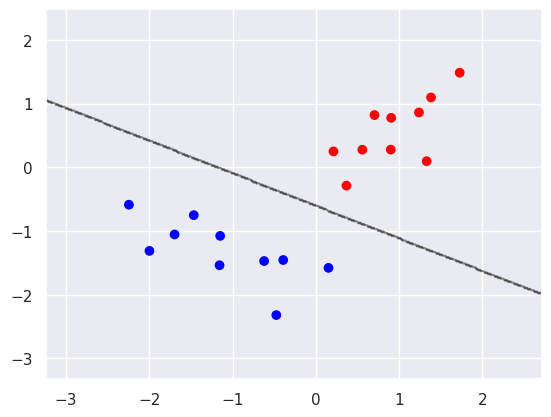

In [3]:
# Generate random points following the Gaussian distributions for the source
mean1 = jnp.array([1, 1])
cov1 = jnp.array([[0.2, 0.1], [0.1, 0.3]])
mean2 = jnp.array([-1, -1])
cov2 = jnp.array([[0.5, -0.4], [-0.2, 0.4]])
n1 = 10
n2 =10

def Generate2DDataset(mean1, cov1, mean2, cov2,n1 = 10,  n2 = 10, randomkey =1):
  """
    Generate random a set of random points following the Gaussian distribution : 
    `n1` points wil be labeled 1 and be distributed w.r.t. a Gaussian law (`mean1`, `cov1`)
    `n2` points wil be labeled -1 and be distributed w.r.t. a Gaussian law (`mean2`, `cov2`)
    """
  key = random.PRNGKey(randomkey)
  x1 = random.multivariate_normal(key, mean1, cov1, (n1,))
  x2 = random.multivariate_normal(key, mean2, cov2, (n2,))
  X = jnp.concatenate([x1, x2])
  y = jnp.concatenate([jnp.ones((n1,)), -jnp.ones((n2,))])
  return x1,x2,X,y

x1,x2,X,y = Generate2DDataset(mean1, cov1, mean2, cov2,n1, n2)


def makeSVM(X,y, kernel = 'linear') :
  "Create a SVM classifier with kernel `kernel` from a dataset of features `X` and labels `y`"
  svm = SVC(kernel=kernel)
  svm.fit(X, y)
  return svm

svm = makeSVM(X,y)

# Plot the data and the decision boundary
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr')
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.show()

In [4]:
# Generate random points following the Gaussian distributions for target 
mean1 = jnp.array([3, 1])
cov1 = jnp.array([[0.4, 0.1], [0.3, 0.5]])
mean2 = jnp.array([3, -2])
cov2 = jnp.array([[0.3, -0.4], [-0.2, 0.4]])
n1_=10
n2_=10
x1_,x2_,X_,y_ = Generate2DDataset(mean1, cov1, mean2, cov2, n1_, n2_, randomkey =2)

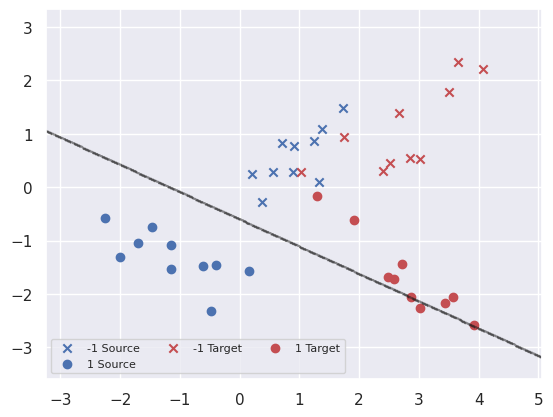

In [5]:
# Plot the data and the decision boundary
colors = ['b', 'r', 'g']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])
x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4),
           ('-1 Source', '1 Source', '-1 Target', '1 Target'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

The reuslting classifier is not at all adapted for the target dataset (in red), so we will use Optimal Transport in the next section. 

## Optimal Transport from source to target dataset

In [6]:
# Plotting the transportation plan
def plot_map(x, y, z, forward: bool = True):
    plt.figure(figsize=(10, 8))
    marker_t = "o" if forward else "X"
    label = (
        r"$T_{x\rightarrow y}(x)$" if forward else r"$T_{y\rightarrow x}(y)$"
    )
    w = x if forward else y
    plt.quiver(
        *w.T,
        *(z - w).T,
        color="k",
        angles="xy",
        scale_units="xy",
        scale=1,
        width=0.007,
    )
    plt.scatter(*x.T, s=200, edgecolors="k", marker="o", label=r"$x$")
    plt.scatter(*y.T, s=200, edgecolors="k", marker="X", label=r"$y$")
    plt.scatter(*z.T, s=150, edgecolors="k", marker=marker_t, label=label)
    plt.legend(fontsize=22)

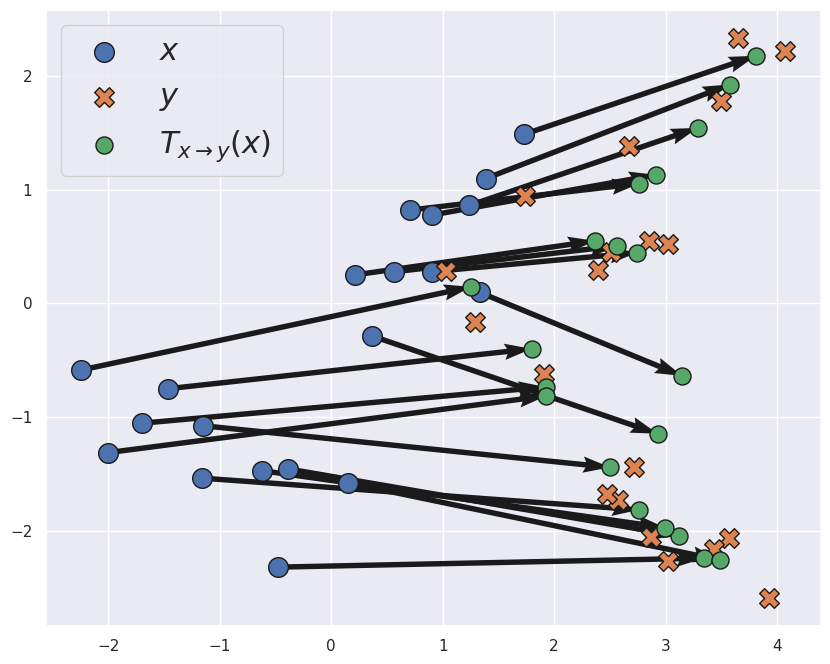

In [7]:
def getTransport(X, X_, cost_fn = costs.SqEuclidean(), plot = True):
  """ Get the transported points from a source set `X` to a target set `X_, where the cost function is defined by `cost_fn`. `plot` = `True` plot the transportation plan if possible. """
  geom = pointcloud.PointCloud(X, X_, cost_fn=cost_fn) #  cost_fn permet de changer la fonction coût ici
  out = sinkhorn.Sinkhorn()(linear_problem.LinearProblem(geom))
  dual_potentials = out.to_dual_potentials() #get the coordinates of transported points
  if plot == True and len(X[0])==2 and len(X_[0]) == 2:
    plot_map(X, X_, dual_potentials.transport(X))
   
  return dual_potentials.transport(X) 

tX = getTransport(X,X_)

We now train the classifier on the transported points `tX` using the source labeled `y`.

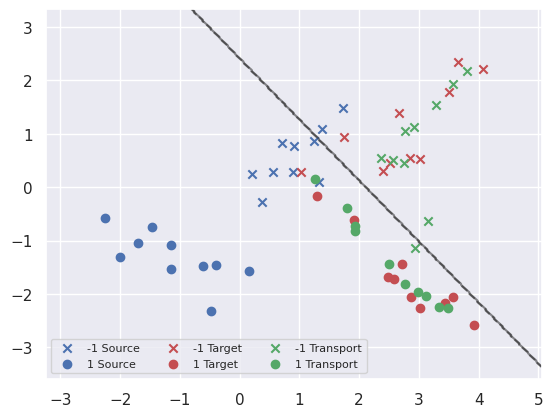

In [8]:
svm = makeSVM(tX,y)

# Plot the data and the decision boundary
colors = ['b', 'r', 'g']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])
p5 = plt.scatter(tX[:,0][:n1], tX[:,1][:n1], marker='x', color=colors[2])
p6 = plt.scatter(tX[:,0][n1:], tX[:,1][n1:], marker='o', color=colors[2])

x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4, p5, p6),
           ('-1 Source', '1 Source', '-1 Target', '1 Target', '-1 Transport', '1 Transport'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

The new classifier is adapted for the transported points (in green), except for one data point in this example. Now this classifier is applied to the target domain.

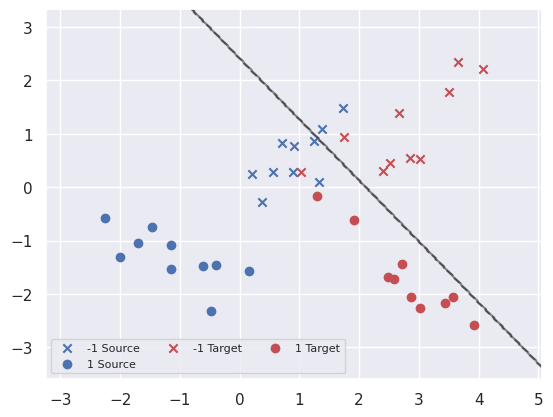

In [9]:
# Plot the data and the decision boundary
colors = ['b', 'r', 'g']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])

x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4),
           ('-1 Source', '1 Source', '-1 Target', '1 Target'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

This new classifier is way more adapted for the target dataset.

## Trying to get the best of both worlds

Each of the classifers are well adapted for the source or the target dataset only. Since the source and target dataset "live" on the same space (here $\mathbb{R}^2$), we're looking for a classifier that seperate fairly all the points (from both the source and the target datasets) labeled -1 and 1.

### First idea : mid transported points

We simply take the middle of the transportation plan and build the classifier on those points.

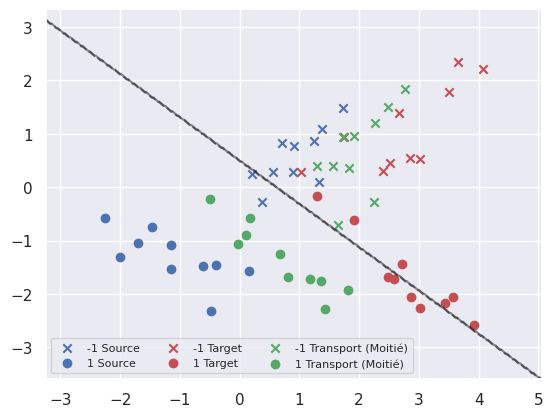

In [10]:
# We plot the boundary decision made for the middle of the transportation plan :
meanX = (tX+X)/2
svm = makeSVM(meanX,y)

# Plot the data and the decision boundary
colors = ['b', 'r', 'g']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])
p5 = plt.scatter(meanX[:,0][:n1], meanX[:,1][:n1], marker='x', color=colors[2])
p6 = plt.scatter(meanX[:,0][n1:], meanX[:,1][n1:], marker='o', color=colors[2])

x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4, p5, p6),
           ('-1 Source', '1 Source', '-1 Target', '1 Target', '-1 Transport (Moitié)', '1 Transport (Moitié)'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

The resulting classifier is not well suited to classify both domains. So we will try a Voting system.

### Second idea : Voting Classifier

We cut out the transport plan into `step` steps, build a classifier for each intermediary step (including the first classifier on the source dataset) and build a voting classifier that will be trained either on all the intermediary steps of the transportation plan or only on the source and final transported points. 

In [11]:
from sklearn.ensemble import VotingClassifier
step = 10

def votingclassifier(X,y, tX,step = 10, longtrain = True):
  """ Build a Voting classifer. The intermediary classifier are trained on each step of the transportation plan
   from the source dataset `X` to the transported dataset `tX` with label `y`, that has been cut out in `step`steps.
   The argument `longtrain` = `True`, `False`or `'both'` defines how the resulting voting classifier(s) is (are) trained : 
   * `True` : on all intermediary dataset
   * `False` :  only on original and transported  dataset
   * `both` : the two previous classifiers are returned"""
  svm0 = makeSVM(X,y)
  X_t = X
  y_t = y
  if longtrain ==False or longtrain =='both':
    X_t2 = jnp.concatenate([X, tX])
    y_t2 = jnp.concatenate([y, y])
  svm = [svm0]
  for i in range(1, step+1):
    newX = ((step-i)/step)*X + (i/step)*tX
    X_t = jnp.concatenate([X_t, newX])
    y_t = jnp.concatenate([y_t, y])
    svm.append(makeSVM(newX,y))

  estimator = []
  for i in range(len(svm)):
    estimator.append((str(i), svm[i]))
  # Create voting ensemble of SVM linear classifiers
  ensemble = VotingClassifier(estimators=estimator, voting='hard')

  # Fit the ensemble on the training data
  if longtrain == False :
    ensemble.fit(X_t2, y_t2)
    return ensemble
  elif longtrain == 'both':
    return ensemble.fit(X_t,y_t), ensemble.fit(X_t2,y_t2)
  else : 
    return ensemble.fit(X_t,y_t)

ensemble1, ensemble2 = votingclassifier(X,y,tX, step, longtrain = 'both')

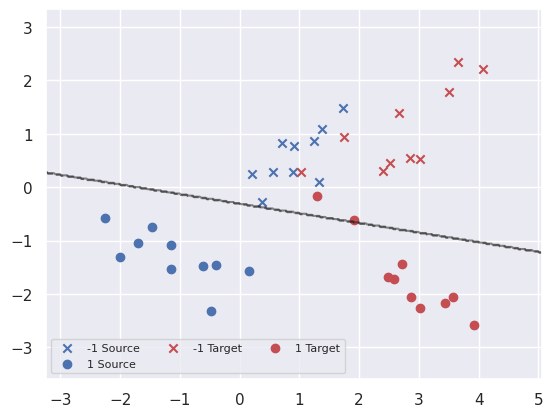

In [12]:
# Plot with the training on all the intermediary steps of the transport plan

svmcolors = ['b', 'r']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])


x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = ensemble1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4),
           ('-1 Source', '1 Source', '-1 Target', '1 Target'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

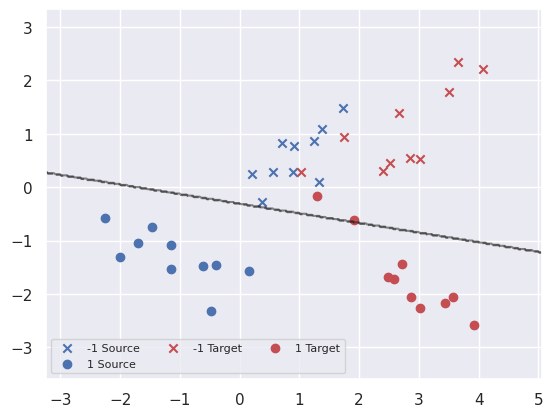

In [13]:
# Plot with the training on the orignal and the transported points

svmcolors = ['b', 'r']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])

x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = ensemble2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

plt.legend((p1, p2, p3, p4),
           ('-1 Source', '1 Source', '-1 Target', '1 Target'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

In both situations , the classifier is well adapted for both domains. The difference is minimal between the two (training of original and transported points or training on original and all intermediary transported points) because the datasets are sufficiently separated.

# Optimal Transport : translated points 

We show the formal and an empirical proof of theorem 3.1 of *Optimal Transport for Domain Adaptation* (Courty et al. 2016):

Let $\mu^s$ and $\mu^{t}$ be two discrete distributions
with $n$ Diracs . If the following conditions hold


1.   The source samples in $\mu^s$ are $x^s_i \in \mathbb{R}^d, \forall i \in 1,...,n$ such that $x^s_i \neq x^s_j, i \neq j$
2.   All weights in the source and target distributions  are $1/n$.
3.   The target samples are defined as $x^t_i = Ax^s_i + b$, *i.e.*  an affine tranformation of the source samples.
4.   $b\in \mathbb{R}^d$ and $A\in\mathcal{S}^+$ is a strictly positive definite matrix.
5.   The cost function is $c(x^s; x^t) = || x^s - x^t ||^2_2$.


Then the solution $T_0$ of the optimal transport problem is so that $T_0(x^s_i
) = Ax^s_i + b = x^t_i, \forall i \in 1,...,n$.

In this case, we get the exact affine transformation on the discrete samples, which means that the label information are fully preserved during
transportation. Therefore, one can train a classifier on the mapped samples with no generalization loss.

In the two plots below, the target domain is just a translation of the source one.



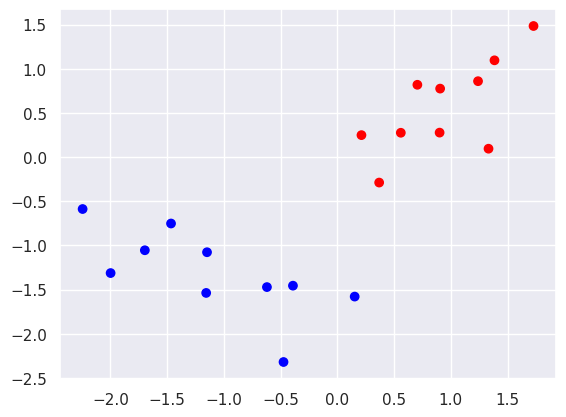

In [16]:
# Generate random points following the Gaussian distributions for the source
mean1 = jnp.array([1, 1])
cov1 = jnp.array([[0.2, 0.1], [0.1, 0.3]])
mean2 = jnp.array([-1, -1])
cov2 = jnp.array([[0.5, -0.4], [-0.2, 0.4]])
n1 = 10
n2 =10
x1,x2,X,y = Generate2DDataset(mean1, cov1, mean2, cov2, n1_, n2_, randomkey =1)

# Plot the data and the decision boundary
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr')
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
plt.show()

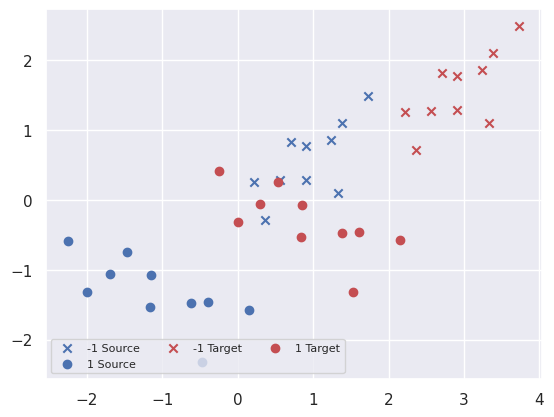

In [17]:
# Generate random points following the Gaussian distributions for target 
mean1 = jnp.array([3, 2])
cov1 = jnp.array([[0.2, 0.1], [0.1, 0.3]])
mean2 = jnp.array([1, 0])
cov2 = jnp.array([[0.5, -0.4], [-0.2, 0.4]])
n1 = 10
n2 =10
x1_,x2_,X_,y_ = Generate2DDataset(mean1, cov1, mean2, cov2, n1_, n2_, randomkey =1)

colors = ['b', 'r']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])
x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1

plt.legend((p1, p2, p3, p4),
           ('-1 Source', '1 Source', '-1 Target', '1 Target'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

We take a small `epsilon` parameter in the Sinkhorn algorithm below to get the approximation of the optimal transportation plan. If `epsilon` is too small, the algorithm diverges. 

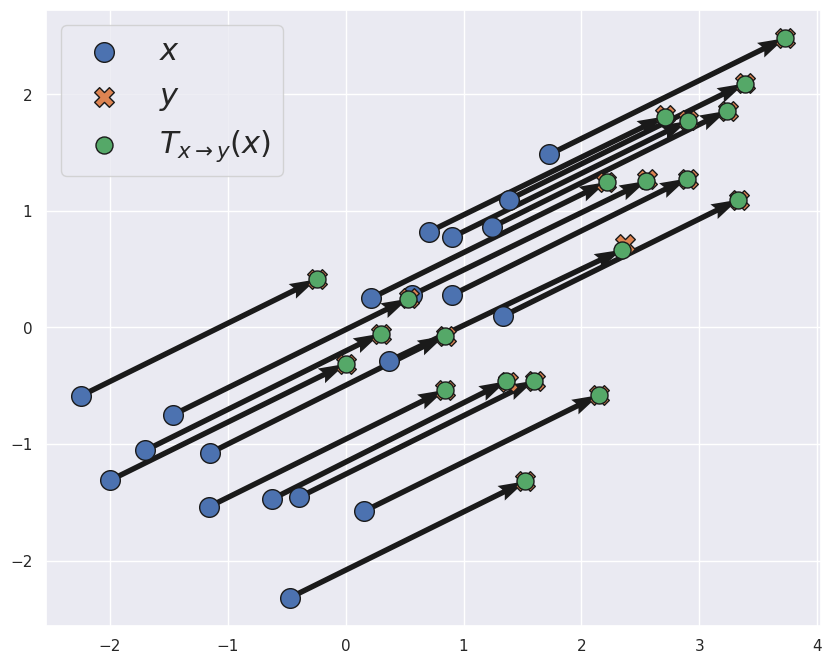

In [18]:
def getTransport_eps(X, X_, cost_fn = costs.SqEuclidean(), plot = True, eps = 0.01):
  """ Get the transported points from a source set `X` to a target set `X_, where the cost function is defined by `cost_fn`. `plot` = `True` plot the transportation plan if possible. """
  geom = pointcloud.PointCloud(X, X_, cost_fn=cost_fn, epsilon = eps) #  cost_fn permet de changer la fonction coût ici
  out = sinkhorn.Sinkhorn()(linear_problem.LinearProblem(geom))
  dual_potentials = out.to_dual_potentials()
  if plot == True and len(X[0])==2 and len(X_[0]) == 2:
    plot_map(X, X_, dual_potentials.transport(X))
   
  return dual_potentials.transport(X)

tX = getTransport_eps(X,X_)

This map coincides with the shift applied to source data to get target data.

This is indeed the result in the paper *Optimal Transport for Domain Adaptation* (see theorem 3.1) and is proven below.


### i) As a reminder, the hypothesis are the following:


* the points are equally weigthed in both the source and the target domains.
* the loss that is used is the square of the $l_2$ distance.
* the points of the source domain are distincts.
* the points of the target domain $(z_i)$ are obtained by the following affine transform on the source points $(x_i)$: $$ z_i = A x_i + b $$

$A$ being a symetric positive definite matrix of $\mathcal{M}_{d}(R)$ and $b$ a vector of $R^d$; which implies that the number of points in both domains are the same: $n$.


### ii) Proof:

One wants to go for $$ P^* \in \textrm{arg}\min_{n P\in \mathcal{C}} <P, C>_F$$ where $<., .>_F$ is the Frobenius scalar product on matrices, $\mathcal{C}$ is the convex envelope of permutation matrices (see the first course of optimal transport) ie $P$ is subject to: $$ P \mathcal{1}  = \mu := (1/n) \mathcal{1} $$ and $$ P^T \mathcal{1}  = \nu := (1/n) \mathcal{1} $$ where $\mathcal{1}$ is the vector of $R^n$ with ones everywhere. 

It has been said in the first course that the Monge map exists in discrete to discrete settings, with the same number of points in the target and the source distribution. 

Indeed given the objective function is linear (one can tranform it to a linear problem using the famous $vec(P)$ notation), $n P$ will be a corner of $\mathcal{C}$, ie a permutation matrix noted $P_{\sigma}$, where $\sigma \in {\huge \sigma}_n$.  One gets $P = \frac{1}{n}P_{\sigma}$ for a certain $\sigma$. This means that the total mass of a given source point is fully attributed to a target point. There is no splitting of the mass of an $x_i$: we get a Monge map where each point of the source distribution is mapped to a unique point: it is actually a function.


Therefore the objective function to minimize becomes (up to a division by $n$):

$$ n <P, C>_F = n \sum_{1\le i,j \le n} \frac{1}{n} P_{\sigma}|_{i, j} \times \Vert x_i - z_j \Vert_2^2 $$
$$= \sum_{1\le i,j \le n} P_{\sigma}|_{i, j} \times \Vert x_i - A x_j - b \Vert_2^2 $$
$$= \sum_{1\le i \le n} P_{\sigma}|_{i, \sigma(i)} \times \Vert x_i - A x_{ \sigma(i)} - b \Vert_2^2 $$ 
$$= \sum_{1\le i \le n} 1 \times \Vert x_i - A x_{ \sigma(i)} - b \Vert_2^2 $$
$$= \sum_{1\le i \le n}  \Vert x_i - A x_{ \sigma(i)} \Vert_2^2 - 2(x_i - A x_{ \sigma(i)})^T b + \Vert b \Vert_2^2 $$ 
$$= \sum_{1\le i \le n}  \Vert x_i - A x_{ \sigma(i)} \Vert_2^2 - 2 \sum_{1\le i \le n} (x_i - A x_{ \sigma(i)})^T b + n \Vert b \Vert_2^2 $$
$$= \sum_{1\le i \le n}  \Vert x_i - A x_{ \sigma(i)} \Vert_2^2 \underbrace{- 2 \left( \sum_{1\le i \le n} x_i^T b - A \sum_{1\le i \le n} x_{ i}^T b \right) +  n \Vert b \Vert_2^2}_{\text{do not depend on $\sigma$}} 
$$

$$= \sum_{1\le i \le n}  \Vert x_i - A x_{ \sigma(i)} \Vert_2^2 + K $$
$$= \sum_{1\le i \le n}  \Vert x_i \Vert_2^2 - 2 \sum_{1\le i \le n} x_i A x_{\sigma(i)} + \sum_{1\le i \le n} \Vert A x_{i} \Vert_2^2 + K $$
$$= - 2 \sum_{1\le i \le n} x_i A x_{\sigma(i)} + K' .$$

Since $A$ is symetric positive definite matrix, $x_i A x_{\sigma(i)}$ is a scalar product in $R^d$. Hence one wants to minimize the following quantity 
$$ \sum_{1\le i \le n} x_i A x_{\sigma(i)} = \sum_{1\le i \le n} < x_i, x_{\sigma(i)} >_A $$

Now 
$$\sum_{1\le i \le n} < x_i, x_{\sigma(i)} >_A  ~~ \le \sum_{1\le i \le n} \Vert x_i \Vert_A  \Vert x_{\sigma(i)} \Vert_A
 \le \left( \sum_{1\le i \le n} \Vert x_i \Vert_A^2 \right)^{0.5}  \left( \sum_{1\le i \le n}  \Vert x_{\sigma(i)} \Vert_A^2 \right)^{0.5} $$
$$ =  \sum_{1\le i \le n} \Vert x_i \Vert_A^2  
$$
By applying successively Cauchy-Schwarz in $\mathbb{R}^d$ on all of the $n$ $< x_i, x_{\sigma(i)} >_A$, and then in  $\mathbb{R}^n$ equiped of its canonical dot product. 

The first inequality can only be an equality if all of the  $n$  C-S inequalities on the $< x_i, x_{\sigma(i)} >_A$ are actually equalities, so this implies that
$$ \sum_{1\le i \le n} < x_i, x_{\sigma(i)} >_A = \sum_{1\le i \le n} \Vert x_i \Vert_A^2  $$
ie
$$  = \frac{1}{2} \left( 2 \sum_{1\le i \le n} \Vert x_i \Vert_A^2  - 2 \sum_{1\le i \le n} < x_i, x_{\sigma(i)} >_A \right) \\ 
 = \frac{1}{2} \left(  \sum_{1\le i \le n} \Vert x_i - x_{\sigma(i)} \Vert_A^2 \right)$$

so
$$\forall i, x_i = x_{\sigma(i)} $$ 
And since they are distinct, $\sigma = id$.


From the formula (11) in 'Optimal Transport for Domain Adaptation', coming from Villani’s book, one gets that for a squared $l_2$ cost, one have for the transported source measure $\hat{\mu}$, for $t = 1$ in (11):
$$
\hat{\mu}=\sum_{i, j} P|_{i, j} \delta_{z_j}
$$

Which is equal to 
$$
\hat{\mu}=\sum_{i} \frac{1}{n} \delta_{z_j}
$$

However by definition of the Monge map $T$ this is also
$$
\hat{\mu}=\sum_{i, j} \frac{1}{n} \delta_{T(x_j)}
$$

so finally $T(x_j) = z_j$ but $z_j = A x_j + b$ therefore  $T(x_j) = A x_j + b$.

# Caltech Office Dataset

The dataset contains images coming from four different domains: Amazon (online merchant), the Caltech-256 image collection, Webcam (images taken from a webcam) and DSLR (images taken from a high resolution digital SLR camera). The variability of the different domains come from several factors: presence/absence of background, lightning conditions, noise, etc. We consider the features set DeCaf: these features are extracted as the sparse activation of
the neurons from the fully connected 6th and 7th layers of a convolutional network trained on imageNet and then fine tuned on the visual recognition tasks considered here. As such, they form vectors with 4096 dimensions.

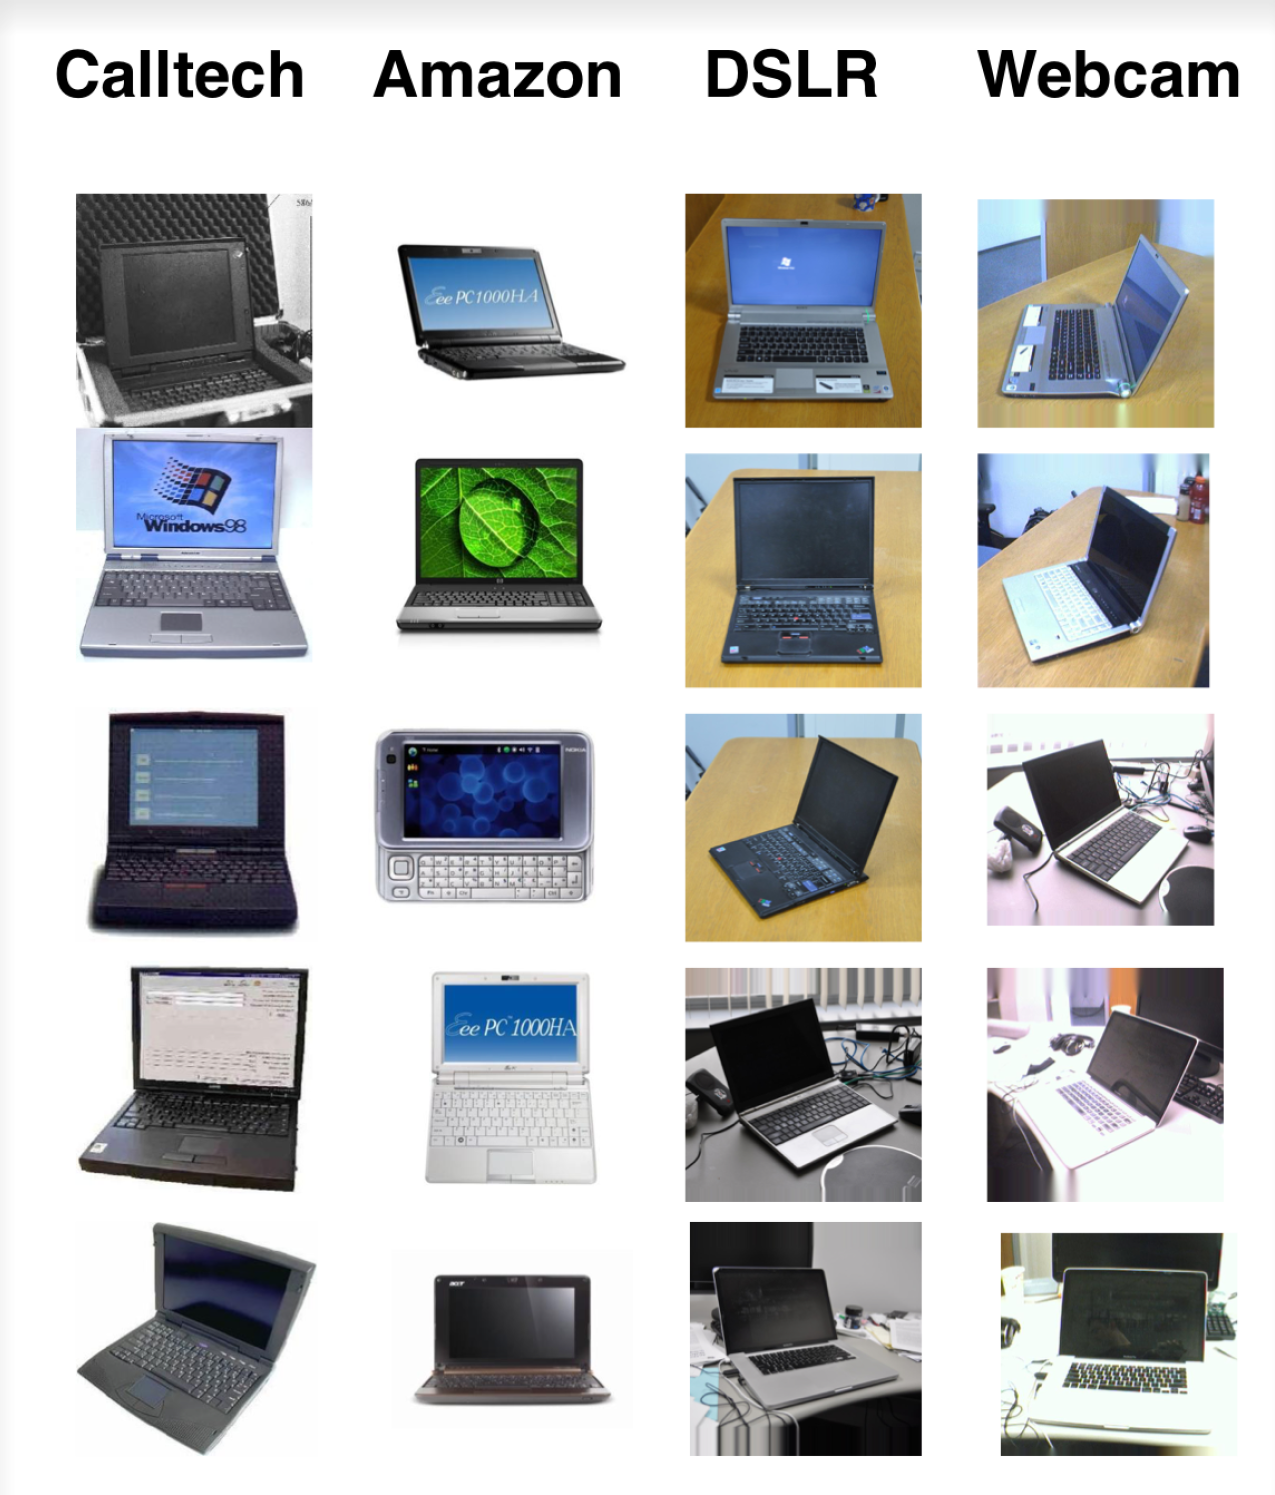

## Get the dataset

In [19]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile


def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)
download_and_unzip('https://github.com/mdlbm/Optimal-Transport-Domain-Adaptation/raw/main/data/decaf6.zip')


In [20]:
import os, sys, traceback
import matplotlib.pylab as pylab
import numpy as np
import pylab as pl
from scipy.io import loadmat
from scipy.stats.mstats import zscore

possible_DTS = ['caltech', 'amazon', 'webcam', 'dslr']

tests = []
data = {}

for ds in possible_DTS:
    if "google.colab" in sys.modules:
      path = '/content/'+ds+'_decaf.mat'
    else :
      path = ds+'_decaf.mat'
    possible_data = loadmat(path)
    feat = possible_data['feas'].astype(float)
    labels = possible_data['labels']
    data[ds]=[feat,labels]


## PCA on the dataset

We use PCA to visualize the ditribution of the datasets (in the same space as outputs of the same computer vision algorithm) and the distribution of the labels in those datasets. 

In [37]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import os.path as osp
import os

def datasets_compare(possible_DTS= possible_DTS):
    if not osp.exists('./content/'):
      os.makedirs('./content/')
    df = pd.DataFrame()
    for i in possible_DTS:
      df1 = pd.DataFrame(data[i][0])
      df1.index=f"{i}."+df1.index.astype('str')
      df1.to_csv('./content/{}.tsv'.format(i), sep = '\t') 
      df = pd.concat([df,df1])

    # df['class'] = df.index
    # df.to_csv('/content/all.tsv'.format(i), sep = '\t')


    df_l = pd.DataFrame()
    for i in possible_DTS:
      df1_l = pd.DataFrame(data[i][1])
      df1_l.index=f"{i}."+df1_l.index.astype('str')
      df1_l.to_csv('./content/{}.tsv'.format(i), sep = '\t') 
      df_l = pd.concat([df_l,df1_l])

    return df, df_l

def get_PCA_datasets(df) : 
    colors = ['red' if i.startswith('caltech') else
          'blue' if i.startswith('amazon') else
          'green' if i.startswith('webcam') else
          'purple' for i in df.index]

    # Instantiate PCA object with 3 components
    pca = PCA(n_components=3)

    # Fit the model with data
    pca.fit(df)

    # Transform the data
    X_pca = pca.transform(df)

    # Plot the results in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c = colors)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.show()

def get_PCA_label(df,df_l):

    label_color_map = {1 : 'red',
                   2 : 'blue',
                   3 : 'green',
                   4 : 'purple',
                   5 : 'orange',
                   6 : 'brown',
                   7 : 'gray',
                   8 : 'pink',
                   9 : 'black',
                   10 : 'yellow'}
    colors = [label_color_map[label] for label in df_l[0]]
    # Instantiate PCA object with 3 components
    pca = PCA(n_components=3)

    # Fit the model with data
    pca.fit(df)

    # Transform the data
    X_pca = pca.transform(df)

    # Plot the results in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c = colors)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.show()


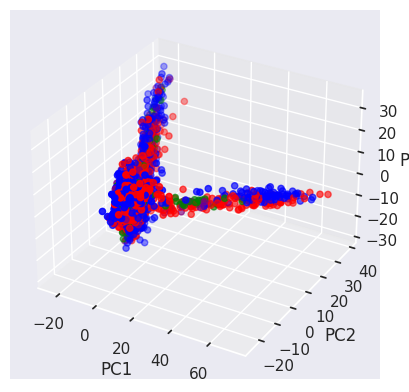

In [48]:
df, df_l = datasets_compare()
df_normalized = df.apply(lambda col: (col-col.mean()) / col.std())

get_PCA_datasets(df_normalized)

The datasets are quite mixed together. 

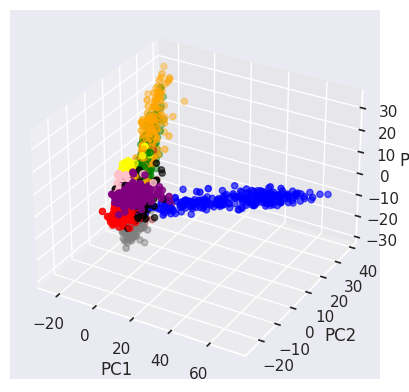

In [49]:
get_PCA_label(df_normalized,df_l)

Label 2 (in blue) seems to be quite distinguishable from the other labels. 

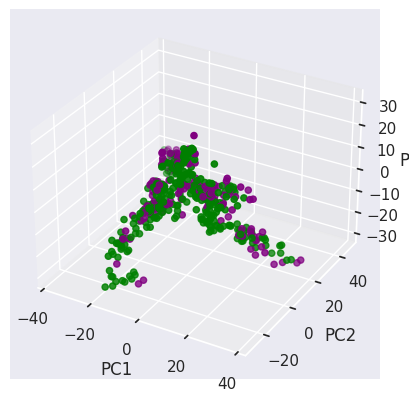

In [52]:
df1, df1_l = datasets_compare(['dslr','webcam'])
df_normalized = df1.apply(lambda col: (col-col.mean()) / (col.std() + 1e-6))

get_PCA_datasets(df_normalized)

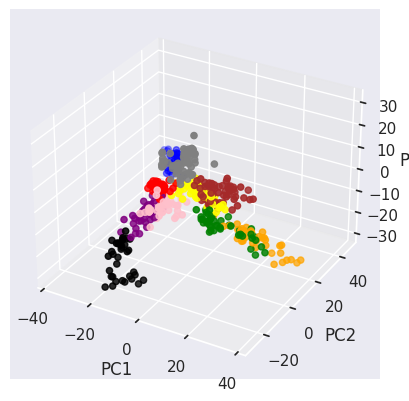

In [53]:
get_PCA_label(df_normalized,df1_l)

In [54]:
for i in possible_DTS:
  print('Size of {} : {}'.format(i, len(data[i][0])))

Size of caltech : 1123
Size of amazon : 958
Size of webcam : 295
Size of dslr : 157


Datasets are quite small, so we will not use a complex classifier to avoid overfitting. Here a small Multi-Layer Perceptron or Random Forest with 5 trees and depth 2 are used. 

## Create a simple MLP for one of the dataset (Caltech)

In [55]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['caltech'][0], data['caltech'][1], test_size=0.1, random_state=42)

# Define the neural network model
model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, alpha=0.01,
                      solver='sgd', verbose=False, random_state=42,
                      learning_rate_init=0.1)
# Train the model
model.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)


/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1091: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.3274336283185841


## Create classifiers by using transportation plans

### Using MLP

In [69]:
import warnings
warnings.filterwarnings("ignore")

In [70]:
#Get model without transport 
def DataTest(dataset1, hidden_sizes = (50,)):
    # Define the neural network model
  model = MLPClassifier(hidden_layer_sizes=hidden_sizes, max_iter=80, alpha=0.01,
                        solver='sgd', verbose=True, random_state=42,
                        learning_rate_init=0.001)

  # Train the model
  model.fit(data[dataset1][0], data[dataset1][1])
  return model

def GetAccuracy(model, dataset2):
  accuracy = model.score(data[dataset2][0], data[dataset2][1])
  return accuracy


# Transport one dataset to another :

def DataTransport(dataset1, dataset2, hidden_sizes = (50,), eps = 0.01):
  trX = getTransport_eps(data[dataset1][0], data[dataset2][0], eps = eps)
  # Define the neural network model
  model = MLPClassifier(hidden_layer_sizes=hidden_sizes, max_iter=80, alpha=0.01,
                        solver='sgd', verbose=True, random_state=42,
                        learning_rate_init=0.001)

  # Train the model
  model.fit(trX, data[dataset1][1])

  # Evaluate the model on the test set
  accuracy = model.score(data[dataset2][0], data[dataset2][1])
  # print("Accuracy:", accuracy)
  return accuracy

The cell below might be a bit long to run.

In [71]:
without_ott = {'caltech':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'amazon':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'webcam':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'dslr':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0}}
with_ott= {'caltech':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'amazon':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'webcam':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'dslr':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0}}
for i in possible_DTS:
  model = DataTest(i, hidden_sizes = (50,))
  for j in possible_DTS:
    without_ott[i][j] = GetAccuracy(model,j)
    if i != j: 
      # print('Accuracy result from {} to {} :'.format(i,j))
      with_ott[i][j] = DataTransport(i,j, hidden_sizes=(50,))
    else :
      with_ott[i][j] = GetAccuracy(model,j)      

Iteration 1, loss = 4.39237512
Iteration 2, loss = 0.92912207
Iteration 3, loss = 0.44624909
Iteration 4, loss = 0.26105826
Iteration 5, loss = 0.16368899
Iteration 6, loss = 0.10531342
Iteration 7, loss = 0.07467965
Iteration 8, loss = 0.05752172
Iteration 9, loss = 0.04677773
Iteration 10, loss = 0.03927623
Iteration 11, loss = 0.03387573
Iteration 12, loss = 0.03007043
Iteration 13, loss = 0.02725626
Iteration 14, loss = 0.02482314
Iteration 15, loss = 0.02272489
Iteration 16, loss = 0.02099264
Iteration 17, loss = 0.01937401
Iteration 18, loss = 0.01812385
Iteration 19, loss = 0.01711481
Iteration 20, loss = 0.01630184
Iteration 21, loss = 0.01556168
Iteration 22, loss = 0.01481459
Iteration 23, loss = 0.01421242
Iteration 24, loss = 0.01368094
Iteration 25, loss = 0.01314230
Iteration 26, loss = 0.01261590
Iteration 27, loss = 0.01215677
Iteration 28, loss = 0.01177614
Iteration 29, loss = 0.01139277
Iteration 30, loss = 0.01104509
Iteration 31, loss = 0.01073920
Iteration 32, los

In [72]:
import pandas as pd
without_ =pd.DataFrame.from_dict(without_ott,orient='index')
# without_.to_csv('/content/without50.csv')
without_

,caltech,amazon,webcam,dslr
caltech,1.000000,0.885177,0.674576,0.783439
amazon,0.740873,1.000000,0.600000,0.668790
webcam,0.559216,0.614823,1.000000,0.929936
dslr,0.552983,0.633612,0.864407,1.000000


The lines designates the original dataset, the rows the target ones. In this table, no optimal transport has been made : the target dataset is directly tested on the classifier trained on the original one. 

In [73]:
with_ =pd.DataFrame.from_dict(with_ott,orient='index')
# with_.to_csv('/content/with50.csv')
with_

,caltech,amazon,webcam,dslr
caltech,1.000000,0.832985,0.725424,0.770701
amazon,0.743544,1.000000,0.596610,0.719745
webcam,0.668744,0.686848,1.000000,0.974522
dslr,0.660730,0.669102,0.945763,1.000000


The lines designates the original dataset, the rows the target ones. In this table, optimal transport has been made : the target dataset is directly tested on the classifier trained on the transported points from the source dataset. 

It is more efficient to use optimal transport for tagging bigger dataset from smaller labeled ones. One can see an improvement with optimal transport, for instance the accuracy of the third line and fourth column goes from approximately 0.930 to 0.975. 

### Using RandomForest

In [65]:
#Get model without transport 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
def DataTestRF(dataset1, n_estimators = 5, max_depth=2, random_state=42):
  classifier = make_pipeline(
    StandardScaler(),
    OneVsRestClassifier(RandomForestClassifier(n_estimators = n_estimators, max_depth= max_depth, random_state=random_state)))

  # Train the model
  classifier.fit(data[dataset1][0], data[dataset1][1])
  return classifier


# Transport one dataset to another :

def DataTransportRF(dataset1, dataset2, n_estimators = 5, max_depth=2, random_state=42, eps = 0.01):
  trX = getTransport_eps(data[dataset1][0], data[dataset2][0], eps = eps)
  # Define the neural network model
  classifier = make_pipeline(
    StandardScaler(),
    OneVsRestClassifier(RandomForestClassifier(n_estimators = n_estimators, max_depth= max_depth, random_state=random_state)))

  # Train the model
  classifier.fit(trX, data[dataset1][1])

  # Evaluate the classifier on the test set
  accuracy = classifier.score(data[dataset2][0], data[dataset2][1])
  # print("Accuracy:", accuracy)
  return accuracy

In [66]:
without_ott = {'caltech':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'amazon':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'webcam':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'dslr':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0}}
with_ott= {'caltech':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'amazon':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'webcam':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'dslr':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0}}
for i in possible_DTS:
  model = DataTestRF(i)
  for j in possible_DTS:
    without_ott[i][j] = GetAccuracy(model,j)
    if i != j: 
      # print('Accuracy result from {} to {} :'.format(i,j))
      with_ott[i][j] = DataTransportRF(i,j)
    else:
      with_ott[i][j] = GetAccuracy(model,j)

In [67]:
without_ =pd.DataFrame.from_dict(without_ott,orient='index')
# without_.to_csv('/content/without.csv')
without_

,caltech,amazon,webcam,dslr
caltech,0.792520,0.727557,0.505085,0.611465
amazon,0.648264,0.894572,0.437288,0.592357
webcam,0.398931,0.493737,0.925424,0.828025
dslr,0.423865,0.482255,0.667797,0.949045


In [68]:
with_ =pd.DataFrame.from_dict(with_ott,orient='index')
# with_.to_csv('/content/with.csv')
with_

,caltech,amazon,webcam,dslr
caltech,0.792520,0.818372,0.752542,0.815287
amazon,0.662511,0.894572,0.633898,0.738854
webcam,0.538736,0.591858,0.925424,0.923567
dslr,0.534283,0.584551,0.810169,0.949045


For tagging dslr from the calltech dataset, we gain 20% of accuracy using optimal transport (comparison of row 1, column 4 in both tables).

To conclude this notebook, using optimal transport for domain adaptation in computer vision tasks increases the performance compared to simply using the classifier of the source domain.

NB : since the different features of the datasets "live" in the same space (output of the sparse activation of a neural network) we could use the Voting Classifier presented above to get the best of the source classifier and the 'target' classifier in a global one. 

